# Cleaning and Averaging ATLAS Light Curves
### Includes chi-square cut, uncertainty cut, control light curve cut, and averaging

This iPython notebook will help you apply each cut with a greater degree of control than an automatic cleaning. You will be walked through the following:
1. Static uncertainty cut
2. Estimating true uncertainties
3. Dynamic chi-square cut
4. Control light curve cut
5. Averaging the light curve and cutting bad bins
6. Optionally correct for ATLAS template changes
7. Save files

After running a cell, the descriptions located above that cell will help you interpret the plots and make decisions about the supernova.

In order for this notebook to work correctly, the ATLAS light curves must already be downloaded and saved. Each light curve must also only include measurements for a single filter. To download SN and control light curves, please refer to the documentation `README.md` and use the download script `download_atlas_lc.py`.

## Settings

<div class="alert alert-block alert-info">
    <b>Tip:</b> Edit the following settings to correspond to your target SN and source directory for data.
</div>


Below we have set example fields for SN 2020lse. Recommended fields to change at a minimum include `tnsname`, `source_dir`, and `discovery_date`.

In [1]:
##### LOADING THE SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2018gkr'

# Enter the path to the data directory that contains the SN directory:
source_dir = f'/Users/sofiarest/Desktop/Supernovae/data/temp' 

# Enter the path to a directory to optionally save any plots:
output_dir = f'{source_dir}/{tnsname}/plots'

# Enter the filter for this light curve (must be 'o' or 'c'):
filt = 'o'

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
discovery_date = 58207.146991
api_key = None
tns_id = None
bot_name = None

##### LOADING CONTROL LIGHT CURVES #####

# Set to True if you are planning on applying the control light curve cut 
# and have already downloaded the control light curves:
load_controls = True

# Enter the number of control light curves to load:
n_controls = 8

# Enter the source directory of the control light curve files:
controls_dir = f'{source_dir}/{tnsname}/controls'

##### PLOTTING #####

# If True, try to calculate the best y limits automatically for each plot;
# if False, leave y limits to matplotlib 
auto_xylimits = True

## Miscellaneous functions (skip this section)

In [2]:
import sys, os
sys.path.insert(1,'../')
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB
from clean_atlas_lc_v2 import CleanAtlasLightCurve
import numpy as np
from copy import deepcopy
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
# plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.rc('legend', fontsize = 10)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['axes.linewidth'] = 1
marker_size = 30
marker_edgewidth = 1.5
sn_flux = 'orange' if filt == 'o' else 'cyan'
sn_flagged_flux = 'red' 
ctrl_flux = 'steelblue'

# ATLAS template change dates (MJD)
tchange1 = 58417
tchange2 = 58882

# 'Mask' column flags
flags = {'chisquare':0x1, 
		 
		 'uncertainty':0x2,
		 
		 'controls_bad':0x400000,
		 'controls_questionable':0x80000,
		 'controls_x2':0x100,
		 'controls_stn':0x200,
		 'controls_Nclip':0x400,
		 'controls_Ngood':0x800,
		 
		 'avg_badday':0x800000,
		 'avg_ixclip':0x1000,
		 'avg_smallnum':0x2000}

def do_manual_xylimits(limits):
    for limit in limits:
        if not limit is None:
            return True
    return False

def set_xylimits(lc, limits, control_index=0, indices=None):
    if auto_xylimits:
        if limits[0] is None:
            limits[0] = lc.lcs[control_index].t['MJD'].min() * 0.999
        if limits[1] is None:
            limits[1] = lc.lcs[control_index].t['MJD'].max() * 1.001
        
        if indices is None:
            indices = lc.get_ix()
        # exclude measurements with duJy > 160
        good_ix = lc.lcs[control_index].ix_inrange(colnames='duJy', uplim=160, indices=indices)
        # get 5% of abs(max flux - min flux)
        flux_min = lc.lcs[control_index].t.loc[good_ix, 'uJy'].min()
        flux_max = lc.lcs[control_index].t.loc[good_ix, 'uJy'].max()
        diff = abs(flux_max - flux_min)
        offset = 0.05 * diff

        if limits[2] is None: 
            limits[2] = flux_min - offset
        if limits[3] is None:
            limits[3] = flux_max + offset

        return limits
    
    if do_manual_xylimits(limits):
        return limits
    
    return None

def save_plot(save_filename=None):
    if not save_filename is None:
        filename = f'{output_dir}/{save_filename}.png'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        print(f'Saving plot: {filename}')
        plt.savefig(filename, dpi=200)

def plot_all_lcs(lc, add2title=None, plot_controls=False, plot_templates=False, limits=None, save_filename=None):
    fig, ax1 = plt.subplots(1, constrained_layout=True)
    fig.set_figwidth(7)
    fig.set_figheight(4)

    title = f'SN {tnsname} & control light curves {filt}-band flux'
    if not(add2title is None):
        title += add2title
    ax1.set_title(title)

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.set_xlabel('MJD')
    ax1.axhline(linewidth=1, color='k')

    # set x and y limits
    limits = set_xylimits(lc, limits)
    if not limits is None:
        ax1.set_xlim(limits[0],limits[1])
        ax1.set_ylim(limits[2],limits[3])

    if plot_templates:
        ax1.axvline(x=tchange1, color='k', linestyle='dotted', label='ATLAS template change', zorder=100)
        ax1.axvline(x=tchange2, color='k', linestyle='dotted', zorder=100)
        #ax1.axvline(x=tchange2, color='k', linestyle='dotted', zorder=100)

    preSN_ix = lc.get_pre_SN_ix()
    postSN_ix = lc.get_post_SN_ix()

    if load_controls and plot_controls:
        for control_index in range(1, lc.num_controls+1):
            plt.errorbar(lc.lcs[control_index].t['MJD'], lc.lcs[control_index].t['uJy'], yerr=lc.lcs[control_index].t[lc.dflux_colnames[control_index]], fmt='none', ecolor=ctrl_flux, elinewidth=1.5, capsize=1.2, c=ctrl_flux, alpha=0.5, zorder=0)
            if control_index == 1:
                plt.scatter(lc.lcs[control_index].t['MJD'], lc.lcs[control_index].t['uJy'], s=marker_size, color=ctrl_flux, marker='o', alpha=0.5, zorder=0, label=f'{lc.num_controls} control light curves')
            else:
                plt.scatter(lc.lcs[control_index].t['MJD'], lc.lcs[control_index].t['uJy'], s=marker_size, color=ctrl_flux, marker='o', alpha=0.5, zorder=0)


    plt.errorbar(lc.lcs[0].t.loc[preSN_ix,'MJD'], lc.lcs[0].t.loc[preSN_ix,'uJy'], yerr=lc.lcs[0].t.loc[preSN_ix,lc.dflux_colnames[0]], fmt='none', ecolor=sn_flux, elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    plt.scatter(lc.lcs[0].t.loc[preSN_ix,'MJD'], lc.lcs[0].t.loc[preSN_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, zorder=10, label='Pre-SN light curve')

    plt.errorbar(lc.lcs[0].t.loc[postSN_ix,'MJD'], lc.lcs[0].t.loc[postSN_ix,'uJy'], yerr=lc.lcs[0].t.loc[postSN_ix,lc.dflux_colnames[0]], fmt='none', ecolor='red', elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    plt.scatter(lc.lcs[0].t.loc[postSN_ix,'MJD'], lc.lcs[0].t.loc[postSN_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color='red', marker='o', alpha=0.5, zorder=10, label='Post-SN light curve')

    ax1.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)

    plt.show()
    save_plot(save_filename=save_filename)

def plot_cut_lc(lc, title, flag, limits=[None]*4, save_filename=None):
    fig, (ax2, ax1) = plt.subplots(2, constrained_layout=True)
    fig.set_figwidth(7)
    fig.set_figheight(5)

    fig.suptitle(f'{title} (flag {hex(flag)})')

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax2.get_xaxis().set_ticks([])
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1, color='k')

    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.set_xlabel('MJD')
    ax2.axhline(linewidth=1, color='k')

    # set x and y limits
    limits = set_xylimits(lc, limits)
    if not limits is None:
        ax1.set_xlim(limits[0],limits[1])
        ax1.set_ylim(limits[2],limits[3])
        ax2.set_xlim(limits[0],limits[1])
        ax2.set_ylim(limits[2],limits[3])

    good_ix = lc.lcs[0].ix_unmasked('Mask', maskval=flag)
    bad_ix = lc.lcs[0].ix_masked('Mask', maskval=flag)

    ax1.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,lc.dflux_colnames[0]], fmt='none', ecolor=sn_flux, elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5)
    ax1.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label='Kept measurements')

    ax2.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,lc.dflux_colnames[0]], fmt='none', ecolor=sn_flux, elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=5)
    ax2.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label='Kept measurements', zorder=5)

    ax2.errorbar(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=lc.lcs[0].t.loc[bad_ix,lc.dflux_colnames[0]], fmt='none', ecolor=sn_flagged_flux, elinewidth=1, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flagged_flux, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label='Cut measurements', zorder=10)

    ax1.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)
    ax2.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)

    save_plot(save_filename=save_filename)
    plt.show()

def fdf_hist(lc, all_controls, x2bound, limits=None, density=True): 
    preSN_ix = lc.get_pre_SN_ix()
    preSN_good_ix = lc.lcs[0].ix_inrange(colnames=['chi/N'], uplim=x2bound, indices=preSN_ix)
    preSN_bad_ix = AnotB(preSN_ix, preSN_good_ix)

    controls_ix = all_controls.t.index.values
    controls_good_ix = all_controls.ix_inrange(colnames=['chi/N'], uplim=x2bound)
    controls_bad_ix = AnotB(controls_ix, controls_good_ix)

    fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True)
    fig.set_figwidth(4.5)
    fig.set_figheight(4.5)

    ax1.set_title('for pre-SN light curve', fontsize=12)
    ax2.set_title('for control light curves', fontsize=12)
    ax2.set_xlabel('µJy/dµJy')
    
    bins = None
    if not limits is None:
        bins = np.linspace(limits[0]-10, limits[1]+10, 20)
        ax1.get_xaxis().set_ticks([])
        ax1.tick_params(direction='in', which='both')
        ax1.set_xlim(limits[0], limits[1])
        ax2.tick_params(direction='in', which='both')
        ax2.set_xlim(limits[0], limits[1])

    ax1.hist(lc.lcs[0].t.loc[preSN_good_ix,'uJy/duJy'], bins=bins, color='green', alpha=0.5, label=f'Data with chi-square<{x2bound}', density=density)
    ax1.hist(lc.lcs[0].t.loc[preSN_bad_ix,'uJy/duJy'], bins=bins, color='red', alpha=0.5, label=f'Data with chi-square≥{x2bound}', density=density)
    
    ax2.hist(all_controls.t.loc[controls_good_ix,'uJy/duJy'], bins=bins, color='green', alpha=0.5, density=density)
    ax2.hist(all_controls.t.loc[controls_bad_ix,'uJy/duJy'], bins=bins, color='red', alpha=0.5, density=density)

    fig.legend(facecolor='white', framealpha=1, loc='upper left',  bbox_to_anchor=(1, 1))
    plt.show()

def fdf_hist_preSNonly(lc, x2bound, limits=None, density=True):
    preSN_ix = lc.get_pre_SN_ix()
    preSN_good_ix = lc.lcs[0].ix_inrange(colnames=['chi/N'], uplim=x2bound, indices=preSN_ix)
    preSN_bad_ix = AnotB(preSN_ix, preSN_good_ix)

    fig, ax1 = plt.subplots(1, constrained_layout=True)
    fig.set_figwidth(4.5)
    fig.set_figheight(2.5)

    ax1.set_title('for pre-SN light curve', fontsize=12)
    ax1.set_xlabel('µJy/dµJy')
    
    bins = None
    if not limits is None:
        bins = np.linspace(limits[0]-10, limits[1]+10, 20)
        ax1.tick_params(direction='in', which='both')
        ax1.set_xlim(limits[0], limits[1])
    
    ax1.hist(lc.lcs[0].t.loc[preSN_good_ix,'uJy/duJy'], bins=bins, color='green', alpha=0.5, label=f'Data with chi-square<{x2bound}', density=density)
    ax1.hist(lc.lcs[0].t.loc[preSN_bad_ix,'uJy/duJy'], bins=bins, color='red', alpha=0.5, label=f'Data with chi-square≥{x2bound}', density=density)

    fig.legend(facecolor='white', framealpha=1, loc='upper left',  bbox_to_anchor=(1, 1))
    plt.show()

def plot_limcuts(limcuts, x2_cut, limits=None, use_preSN_lc=False):
    loss_color = 'darkmagenta'
    contam_color = 'teal'

    fig, ax1 = plt.subplots(1, constrained_layout=True)
    fig.set_figwidth(5.5)
    fig.set_figheight(3)

    #ax1.set_title(f'SN {tnsname} {filt}-band chi-square cut')

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    if use_preSN_lc:
        ax1.set_ylabel(f'% pre-SN light curve measurements')
    else:
        ax1.set_ylabel(f'% control light curve measurements')
    ax1.set_xlabel('Chi-square cut')
    ax1.axhline(linewidth=1, color='k')

    ax1.plot(limcuts['PSF Chi-Square Cut'].values, limcuts['Ploss'].values, ms=3.5, color=loss_color, marker='o', label='Loss')
    ax1.plot(limcuts['PSF Chi-Square Cut'].values, limcuts['Pcontamination'].values, ms=3.5, color=contam_color, marker='o', label='Contamination')

    ax1.axvline(x2_cut, color='k', linestyle='dashed', label='Selected cut')

    ax1.set_xlim(0,50)
    ax1.set_ylim(0, max(max(limcuts['Ploss']), max(limcuts['Pcontamination']))*1.1)
    if not limits is None:
        ax1.set_xlim(limits[0], limits[1])
        ax1.set_ylim(limits[2], limits[3])

    ax1.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.show()

def hist_stats(stats, use_preSN_lc=False):
    fig, ax1 = plt.subplots(1, constrained_layout=True)
    fig.set_figwidth(5)
    fig.set_figheight(4)
    #if use_preSN_lc:
    #    ax1.set_title('Distributions across pre-SN light curve')
    #else:
    ax1.set_title('Distributions across control light curves')
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(f'Freq')

    max_y = max(max(stats['median_dflux']), max(stats['stdev']), max(stats['sigma_extra']))
    bins = np.linspace(0, max_y+3, 10)
    median_sigma_extra = np.median(stats['sigma_extra'])
    
    ax1.hist(stats['median_dflux'], bins=bins, alpha=0.5, label=r'median $\delta uJy$')
    
    ax1.hist(stats['stdev'], bins=bins, alpha=0.5, label=r'$\sigma_{uJy}$')

    ax1.hist(stats['sigma_extra'], bins=bins, alpha=0.5, label=r'$\sigma_{extra}$')
    ax1.axvline(median_sigma_extra, color='green', label=r'median $\sigma_{extra}$')

    ax1.legend(facecolor='white', framealpha=1, loc='upper left',  bbox_to_anchor=(1, 1))
    plt.show()

def plot_true_uncertainties(lc, limits=None, save_filename=None):
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    fig.set_figwidth(7)
    fig.set_figheight(5)

    ax1.set_title(f'SN {tnsname} {filt}-band flux\nbefore true uncertainties estimation')
    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1, color='k')

    ax2.set_title(f'after true uncertainties estimation')
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax2.set_xlabel('MJD')
    ax2.axhline(linewidth=1, color='k')

    # set x and y limits
    limits = set_xylimits(lc, limits)
    if not limits is None:
        ax1.set_xlim(limits[0],limits[1])
        ax1.set_ylim(limits[2],limits[3])
        ax2.set_xlim(limits[0],limits[1])
        ax2.set_ylim(limits[2],limits[3])

    ax1.errorbar(lc.lcs[0].t['MJD'], lc.lcs[0].t['uJy'], yerr=lc.lcs[0].t['duJy'], fmt='none', ecolor=sn_flux, elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5)
    ax1.scatter(lc.lcs[0].t['MJD'], lc.lcs[0].t['uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5)

    ax2.errorbar(lc.lcs[0].t['MJD'], lc.lcs[0].t['uJy'], yerr=lc.lcs[0].t['duJy_new'], fmt='none', ecolor=sn_flux, elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5)
    ax2.scatter(lc.lcs[0].t['MJD'], lc.lcs[0].t['uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5)

    save_plot(save_filename=save_filename)
    plt.show()

## Step 1: Load the ATLAS light curves 

In [3]:
print(f'SN {tnsname}, filter {filt}, {n_controls} control light curves')
if not discovery_date is None:
    print(f'SN discovery date: {discovery_date}')
print(f'Source directory (load SN light curve): {source_dir}/{tnsname}')
if load_controls: 
    print(f'Controls directory (load control light curves): {controls_dir}')
print(f'Output directory (save plots): {output_dir}')

SN 2018gkr, filter o, 8 control light curves
SN discovery date: 58207.146991
Source directory (load SN light curve): /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr
Controls directory (load control light curves): /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/controls
Output directory (save plots): /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots


In [4]:
if filt != 'o' and filt != 'c': 
	raise RuntimeError('Filter must be "o" or "c"!')
lc = CleanAtlasLightCurve(filt, tnsname=tnsname, discdate=discovery_date)

# get discovery date
if lc.discdate is None:
	lc._get_tns_data(tnsname, api_key, tns_id, bot_name)
	
# new text file that will contain record of each cut, etc.
f = open(f'{source_dir}/{lc.tnsname}/{lc.tnsname}_output.md', 'w')
f.write(f'# SN {lc.tnsname} Light Curve Cleaning and Averaging\n\nFilter: {lc.filt}-band\nDiscovery date: {lc.discdate}\nNumber of control light curves: {n_controls}')

# load SN and control light curves
lc._load(source_dir, filt, n_controls)

print('\nPreparing for cleaning...')
lc.prep_for_cleaning()
print(lc)


Loading SN light curve and 8 control light curves...

Preparing for cleaning...
# Dropping extra columns (SN light curve):  ['__tmp_SN']
# Clearing 'Mask' column, replacing infs, and calculating flux/dflux in all light curves...
# Making sure SN and control light curve MJDs match up exactly...
## MJDs out of agreement for control light curve 001, fixing...
## MJDs out of agreement for control light curve 002, fixing...
## MJDs out of agreement for control light curve 003, fixing...
## MJDs out of agreement for control light curve 004, fixing...
## MJDs out of agreement for control light curve 005, fixing...
## MJDs out of agreement for control light curve 007, fixing...
## MJDs out of agreement for control light curve 008, fixing...
# Success
SN 2018gkr light curve: RA None, Dec None, discovery date 58207.146991 MJD


### Plot SN and control light curves

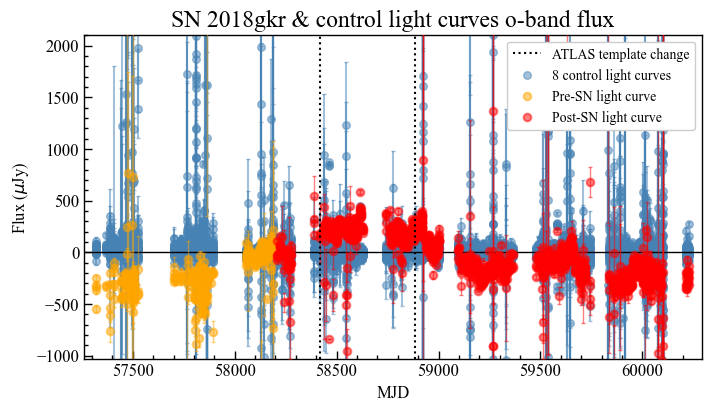

In [5]:
# Plot control light curves underneath SN light curve?
plot_controls = True

# Optionally, manually enter the x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
plot_all_lcs(lc, plot_controls=plot_controls, plot_templates=True, limits=limits)

## Step 2: Static uncertainty cut

The following uncertainty cut implements a static cut that applies the same way to each light curve. The purpose of this cut is to identify and clean out the most egregious outliers with large uncertainties and small chi-square values that would not be cut out in the dynamic chi-square cut. The default value of this cut (160) was determined after calculating the typical uncertainty of bright stars just below the saturation limit. 

<div class="alert alert-block alert-warning">
    <b>Warning:</b> If the SN is particularly bright, you may want to increase the value of the cut and rerun this portion.
</div>

In [6]:
# You may change the following static uncertainty cut value to your liking;
# however, the default value is 160.
uncertainty_cut = 160

In [7]:
output = lc._apply_uncert_cut(flags['uncertainty'], uncertainty_cut)
f.write(f'\n\n## Uncertainty cut\n{output}')
print('Success')


Applying uncertainty cut of 160.00...
# Total percent of data flagged (0x2): 3.91%
Success


### Plot the uncertainty cut

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots/uncertainty_cut.png


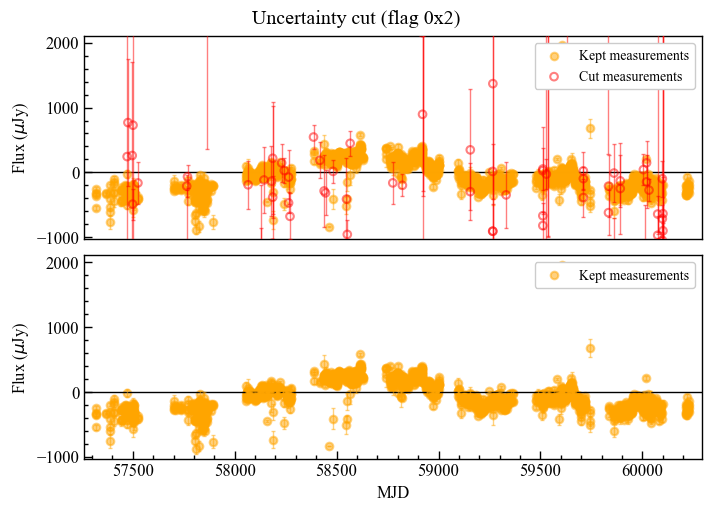

In [8]:
# Plot the light curve before and after the applied uncertainty cut?:
plot = True

# Optionally, manually enter the x and y limits for the uncertainty cut plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

if plot:
    limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
    plot_cut_lc(lc, 'Uncertainty cut', flags['uncertainty'], limits=limits, save_filename='uncertainty_cut')

## Step 3: Estimating true uncertainties by calculating a systematic error contribution

This section attempts to account for an extra noise source in the data by estimating the true typical uncertainty, deriving the additional systematic uncertainty, and lastly applying this extra noise to a new uncertainty column. This new uncertainty column will be used in the cuts following this section.

Note: We refer to flux as $\mu Jy$ and to the uncertainties as $\delta \mu Jy$, as they are referred to in the ATLAS light curve columns.

Here is the procedure we use:
1. We use the control light curves for this analysis since we don't have to worry about any real astrophysical flux in the light curves. We apply the uncertainty cut described above, and also apply a preliminary cut on the PSF fit chi-square cut at 20 (default value). Any measurements flagged by these two cuts are filtered out.  
2. From these measurements, (1) calculate the typical uncertainty $\delta \mu Jy_{\text{typical}}$ as the median of the nominal uncertainties in the $\delta \mu Jy$ column. (2) We calculate the true typical error as the 3-sigma clipped standard deviation $\sigma_{\mu Jy}$ of the flux in the uJy column. In the ideal world, $\delta \mu Jy_{\text{typical}}$ $\approx$ $\sigma_{\mu Jy}$. However, there are often additional error sources, and we calculate the sum of these additional error sources $\sigma_{extra}$ for each control light curve using the following relation (we set $\sigma_{extra}=0.0$ if $\sigma_{\mu Jy}$<$\delta \mu Jy_{\text{typical}}$):
       
    - $\sigma_{\mu Jy}^2$ = $\delta \mu Jy_{\text{typical}}^2$ +  $\sigma_{extra}^2$

3. Calculate the final extra noise source by taking the median of all $\sigma_{extra}$.
4. Apply the extra noise source to the existing uncertainty using the following formula:
    - $\delta \mu Jy_{new}^2 = \delta \mu Jy^2 + \sigma_{extra}^2$
6. For cuts following this procedure, use the new uncertainty column with the extra noise added instead of the old uncertainty column.

In [9]:
# Enter a preliminary chi-square cut (keep at a high number; default is 20):
prelim_x2_cut = 20


Applying true uncertainty estimation...
              median_dflux      stdev sigma_extra
control_index                                    
1                     20.0   26.17717   16.889174
2                     20.0   22.26684    9.788368
3                     20.0   25.43365   15.712114
4                     20.0   22.62232   10.572103
5                     20.0  24.770642   14.614538
6                     20.0  23.237449   11.831274
7                     20.0  27.550442   18.948004
8                     20.0  24.003498   13.272826


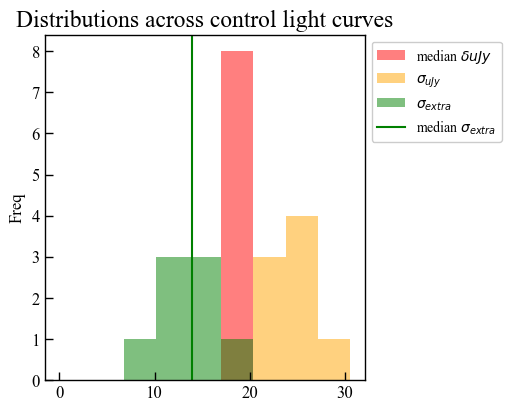

# Final sigma extra: 13.94
# We increase the typical uncertainties from 20.00 to 24.38 by adding an additional systematic uncertainty of 13.94 in quadrature
# New typical uncertainty is 21.90% greater than old typical uncertainty
# Calculating new uncertainties in 'duJy_new' column for each light curve...
Success
Quick sanity check:
            MJD  uJy  duJy   duJy_new
0  57319.574461 -361    39  41.417705
1  57319.587246 -318    28  31.279806
2  57319.600039 -546    34  36.748146
3  57319.611943 -338    30  33.082114
4  57319.636298 -251    28  31.279806


267

In [10]:
def apply_uncert_est(lc, uncert_flag, prelim_x2_cut):
    print('\nApplying true uncertainty estimation...')

    stats = lc._get_uncert_est_stats(uncert_flag, prelim_x2_cut)
    print(stats)
    hist_stats(stats)
    final_sigma_extra = lc._get_final_sigma_extra(stats)
    print(f'# Final sigma extra: {final_sigma_extra:0.2f}')
    
    sigma_typical_old = np.median(stats['median_dflux'])
    sigma_typical_new = np.sqrt(final_sigma_extra**2 + sigma_typical_old**2)
    percent_greater = 100 * ((sigma_typical_new - sigma_typical_old)/sigma_typical_old)
    
    s1 = f'We increase the typical uncertainties from {sigma_typical_old:0.2f} to {sigma_typical_new:0.2f} by adding an additional systematic uncertainty of {final_sigma_extra:0.2f} in quadrature'
    print(f'# {s1}')
    print(f'# New typical uncertainty is {percent_greater:0.2f}% greater than old typical uncertainty')
    if percent_greater >= 10:
        answer = input('True uncertainties estimation recommended. Proceed? (y/n)')
        if answer == 'y':
            print('# Calculating new uncertainties in \'duJy_new\' column for each light curve...') 
            output = f'{s1}\nThe extra noise was added to the uncertainties of the SN light curve and copied to the "duJy_new" column'
            lc._add_noise(final_sigma_extra)
    
            print('Success')
            print('Quick sanity check:')
            print(lc.lcs[0].t[['MJD', 'uJy', 'duJy', 'duJy_new']].head())
            
            #if plot:
            #    plot_true_uncertainties(lc, limits=limits, save_filename='true_uncerts')
        else:
            s2 = 'Skipping procedure'
            output = f'{s2}'
            print(f'# {s2}')
    else:
        s3 = f'True uncertainties estimation not needed; skipping procedure'
        output = f'{s3}.'
        print(s3)
    return lc, output

lc, output = apply_uncert_est(lc, flags['uncertainty'], prelim_x2_cut)
f.write(f'\n\n## True uncertainties estimation\n{output}')

### Plot the true uncertainties estimation

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots/true_uncerts.png


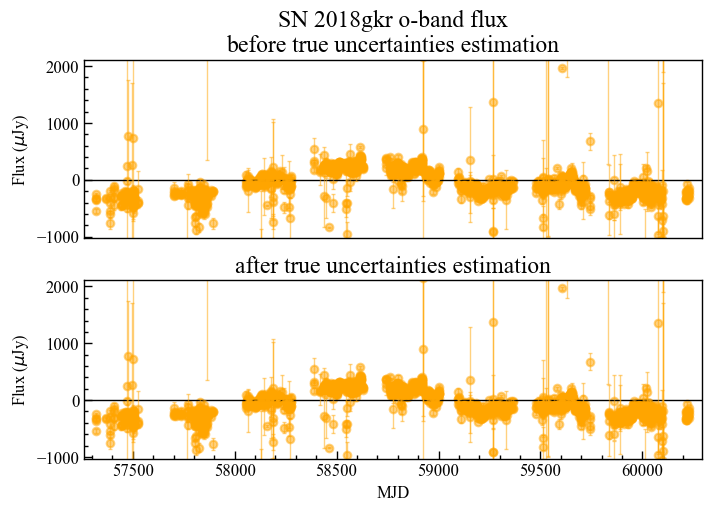

In [11]:
# Plot the light curve before and after estimating true uncertainties?:
plot = True

# Optionally, manually enter the x and y limits for the plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

if plot and 'duJy_new' in lc.lcs[0].t.columns:
    plot_true_uncertainties(lc, limits=limits, save_filename='true_uncerts')

## Step 4: Dynamic chi-square cut

We use two factors, <strong>contamination</strong> and <strong>loss</strong>, to analyze a PSF chi-square cut for the target SN, with flux/dflux as the deciding factor of what constitutes a good measurement vs. a bad measurement. 

We decide what will determine a good measurement vs. a bad measurement using a factor outside of the chi-square values. Our chosen factor is the absolute value of flux (µJy) divided by dflux (dµJy). The recommended boundary is a value of 3, such that any measurements with |µJy/dµJy| <= 3 are regarded as "good" measurements, and any measurements with |µJy/dµJy| > 3 are regarded as "bad" measurements. You can set this boundary to a different number by changing the value of `fdf_bound` below. 

We aim to separate good measurements from bad using the calculated chi-square cut by <strong>minimizing as much loss *and* contamination as possible</strong>. 
- We define contamination $C$ for a certain chi-square cut to be the number of bad kept measurements over the total number of kept measurements.
    - $C = N_{bad, kept}/N_{kept}$
- We define loss $L$ for a certain chi-square cut to be the number of good cut measurements over the total number of good measurements.
    - $L = N_{good,cut}/N_{good}$
- We set the upper and lower bounds of a range of possible cuts for which to calculate $C$ and $L$. We start at a low value of 3 (which can be changed by setting the value of `cut_start` below) and end at 50 (this value is inclusive and can be changed by setting the value of `cut_stop` below) with a step size of 1 (`cut_step` below). For chi-square cuts falling on or between `cut_start` and `cut_stop` in increments of `cut_step`, we can begin to calculate contamination and loss percentages.
- Since we can assume that the expected value of the control light curve flux is 0, we use these measurements by default to calculate and plot contamination and loss for the range of possible cuts.

We set our default chi-square cut to 5, and defer overriding of that cut for a particular SN to the user, given informative plots on alternative cuts with respect to contamination and loss. The user can override this cut by changing the `x2_cut` field and rerunning the following cells.

<div class="alert alert-block alert-warning">
<b>Warning:</b> For very bright SNe, the chi-square values may increase during the SN even for good measurements due to imperfection in PSF fitting. Therefore, we recommend that the user double-check the chi-square values (or this section's plots) to verify that the cut is working as intended, and override the cut with a custom value if needed. The user can rerun the following cells in order to reapply a custom cut.
</div>

In [12]:
# You may change the following PSF chi-square cut value to your liking;
# however, the default value is 5.
x2_cut = 10

# Enter the bound that should separate a good |flux/dflux| measurement from a bad one
# (will be used when calculating contamination and loss):
fdf_bound = 3.0

# Enter the bounds for the range of possible chi-square cuts for which to 
# calculate contamination and loss (minimum cut, maximum cut, and step):
cut_start = 3 # this is inclusive
cut_stop = 50 # this is inclusive
cut_step = 1

# If set to True, we use the pre-SN light curve to calculate contamination and loss.
# If set to False, we use the control light curves (recommended).
use_preSN_lc = False

In [13]:
def get_percent_greater(a, b):
    return 100 * ((a - b)/b)

def sanity_check(lc, all_controls, chisquare_cut):
    postSN_ix = lc.get_post_SN_ix()
    postSN_kept_ix, postSN_cut_ix = lc._get_keptcut_ix(lc.lcs[0], postSN_ix, chisquare_cut)
    postSN_percent_cut = len(postSN_cut_ix)/len(postSN_ix)

    preSN_ix = lc.get_pre_SN_ix()
    preSN_kept_ix, preSN_cut_ix = lc._get_keptcut_ix(lc.lcs[0], preSN_ix, chisquare_cut)
    preSN_percent_cut = len(preSN_cut_ix)/len(preSN_ix)

    controls_ix = all_controls.t.index.values
    controls_kept_ix, controls_cut_ix = lc._get_keptcut_ix(all_controls, controls_ix, chisquare_cut)
    controls_percent_cut = len(controls_cut_ix)/len(controls_ix)

    postSN_percent_greater = get_percent_greater(postSN_percent_cut, controls_percent_cut)
    preSN_percent_greater = get_percent_greater(preSN_percent_cut, controls_percent_cut)

    print('\nSanity check:')
    print(f'# {controls_percent_cut:0.4f}% of measurements cut in control light curves')

    out = f'{preSN_percent_cut:0.4f}% of measurements cut in pre-SN light curve'
    if preSN_percent_greater >= 50:
        out = f'# WARNING: {out} (increase by a factor of approx. {preSN_percent_greater/100+1:0.2f})'
        out += f'\n  Bright SNe may cause the chi-square values to increase even at good measurements due to PSF fitting imperfections. Please double check the plot.'
    else:
        out = f'# {out}'
    print(out)
    
    out = f'{postSN_percent_cut:0.4f}% of measurements cut during and after SN discovery date'
    if postSN_percent_greater >= 50:
        out = f'# WARNING: {out} (increase by a factor of approx. {postSN_percent_greater/100+1:0.2f})'
        out += f'\n  Bright SNe may cause the chi-square values to increase even at good measurements due to PSF fitting imperfections. Please double check the plot.'
    else:
        out = f'# {out}'
    print(out)

def select_x2_cut(x2_cut, lc_temp, ix, good_ix, bad_ix):
    data = lc._get_limcuts_data(lc_temp, x2_cut, ix, good_ix, bad_ix)
    print(f'# Selected chi-square cut of {x2_cut:0.2f}, with contamination of {data["Pcontamination"]:0.2f}% and loss of {data["Ploss"]:0.2f}')
    return data

if load_controls:
    all_controls = lc._get_all_controls()

if use_preSN_lc or not load_controls:
    lc_temp = lc.lcs[0]
    ix = lc_temp.ix_inrange('MJD', uplim=discovery_date)
else:
    lc_temp = all_controls
    ix = lc_temp.t.index.values

good_ix, bad_ix = lc._get_goodbad_ix(lc_temp, ix, fdf_bound)

# get contamination and loss for range of possible cuts
limcuts = lc._get_limcuts_table(lc_temp, ix, good_ix, bad_ix, cut_start, cut_stop, cut_step)

# get contamination and loss for selected cut
data = select_x2_cut(x2_cut, lc_temp, ix, good_ix, bad_ix)

output = lc._apply_x2_cut(x2_cut, data, flags['chisquare'])
if load_controls:
    sanity_check(lc, all_controls, x2_cut)

# Calculating loss and contamination for chi-square cuts from 3 to 50...
# Selected chi-square cut of 10.00, with contamination of 0.81% and loss of 0.04

Applying chi-square cut of 10.00...
# Chi-square cut 10.00 selected with 0.81% contamination and 0.04% loss
# Total percent of data flagged (0x1): 0.50%
Success

Sanity check:
# 0.0030% of measurements cut in control light curves
# 0.0044% of measurements cut in pre-SN light curve
# WARNING: 0.0052% of measurements cut during and after SN discovery date (increase by a factor of approx. 1.74)
  Bright SNe may cause the chi-square values to increase even at good measurements due to PSF fitting imperfections. Please double check the plot.


### Plot the flux/dflux distribution

The following histogram displays the flux/dflux distribution of the SN and control light curves. In green, we plot flux/dflux (µJy/dµJy) measurements with a chi-square value less than or equal to `x2_cut`, which is currently set to 5 below; in red, we plot flux/dflux (µJy/dµJy) measurements with a chi-square value greater than `x2_cut`. 

Ideally, all measurements with chi-square value <= `x2_cut` should have |µJy/dµJy| <= `fdf_bound`, and measurements with chi-square > `x2_cut` should have |µJy/dµJy| > `fdf_bound`. Our goal is to separate good measurements from bad measurements using a chi-square cut; in order for our cut to be effective, this histogram should hopefully showcase this relation between the target SN's |µJy/dµJy| and chi-square measurements.

Note that the histogram will show <strong>probability density</strong> so as to ease comparison between the groups plotted within each histogram. You can change this by toggling the `density` field below.

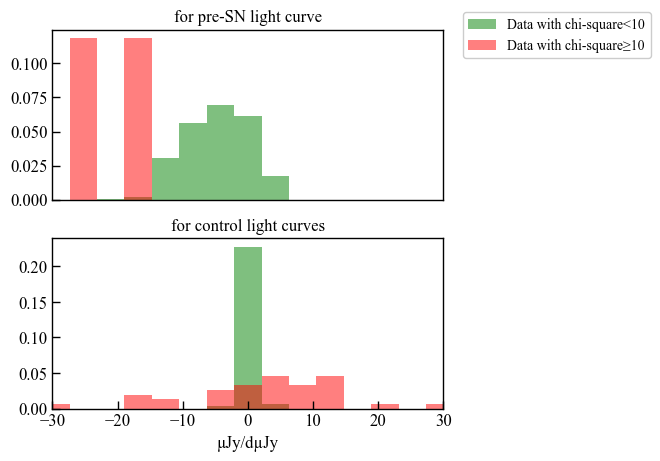

In [14]:
# Plot the flux/dflux distribution?:
plot = True

# Optionally, use probability density (if True, each bin will display the bin's raw count divided by total count and bin width)
density = True

# Optionally, manually enter the histogram's x limits here:
xlim_lower = -30
xlim_upper = 30

if plot:
    if use_preSN_lc or not load_controls:
        fdf_hist_preSNonly(lc, x2_cut, limits=[xlim_lower, xlim_upper], density=density)
    else:
        fdf_hist(lc, all_controls, x2_cut, limits=[xlim_lower, xlim_upper], density=density)

### Plot the loss and contamination for range of chi-square cuts

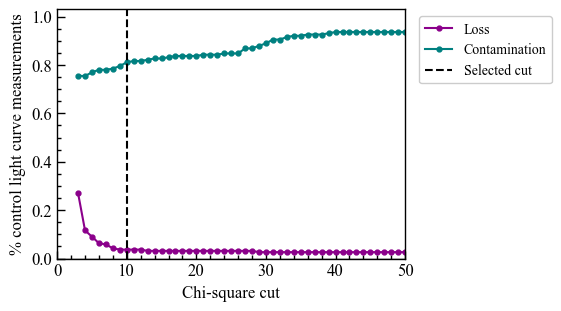

In [15]:
# Plot the loss and contamination for a series of possible chi-square cuts?
plot = True

# Optionally, manually enter the x and y limits for the contamination and loss plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

if plot:
    limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
    plot_limcuts(limcuts, x2_cut, limits=limits, use_preSN_lc=use_preSN_lc)

### Apply and plot the selected chi-square cut

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots/chisquare_cut.png


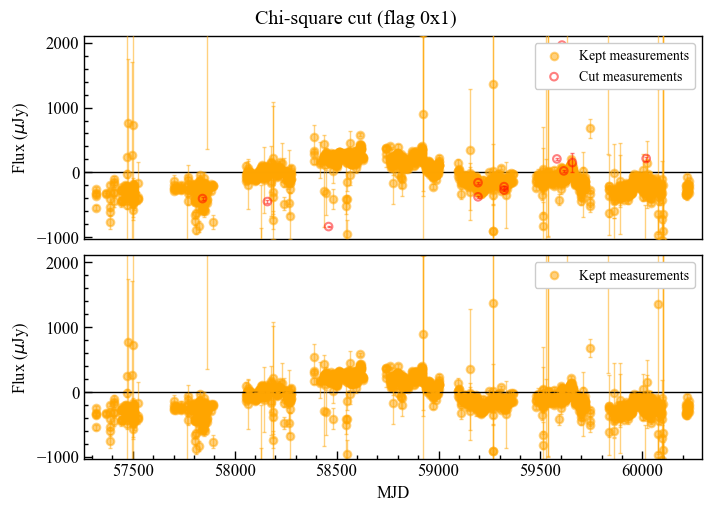

In [16]:
# Plot the light curve before and after the applied chi-square cut?:
plot = True

# Optionally, manually enter the x and y limits for the chi-square cut plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

if plot:
    limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
    plot_cut_lc(lc, 'Chi-square cut', flags['chisquare'], limits=limits, save_filename='chisquare_cut')

## Step 5: Control light curves:  3σ-clipped average cut

While the chi-square and uncertainty cuts are effective in cutting out a majority of the bad measurements, tricky cases may require a larger set of control light curves that can be used as a basis of comparison for inconsistent flux. In order to account for this inconsistent flux, we can obtain ~8 quality control forced photometry light curves in a 17" circle pattern around the SN location OR around a nearby bright object that may be poorly subtracting. Then, we use statistics from these control light curves to cut bad measurements from the SN light curve.

For a given epoch, we have 1 SN measurement for which we examine 8 control measurements within the same epoch. We know that if the control light curve measurements are NOT consistent with 0, this indicates something wrong with this epoch, so the SN measurement is unreliable. Therefore, we obtain statistics for the control light curves by calculating the 3σ-clipped average of the control flux. 

For the given epoch, we cut the SN measurement for which the returned control statistics fulfill any of the following criteria: 
- A returned chi-square > 2.5
- A returned |flux/dflux| > 3.0
- Number of clipped/"bad" measurements in the 3σ-clipped average > 2
- Number of used/"good" measurements in the 3σ-clipped average < 4

Measurements not fulfilling any of the criteria above but with Nclip > 0 are flagged as questionable.

In [17]:
# Enter the bound for an epoch's maximum chi-square 
# (if chi-square value > x2_max, flag SN measurement):
x2_max = 2.5

# Enter the bound for an epoch's maximum abs(flux/dflux) ratio 
# (if |flux/dflux| > stn_max, flag SN measurement):
stn_max = 3.0

# Enter the bound for an epoch's maximum number of clipped control measurements
# (if Nclip > Nclip_max, flag SN measurement):
Nclip_max = 2

# Enter the bound for an epoch's minimum number of good control measurements
# (if Ngood < Ngood_min, flag SN measurement):
Ngood_min = 4

In [18]:
if load_controls:
    output = lc._apply_controls_cut(flags, x2_max, stn_max, Nclip_max, Ngood_min)
    f.write(f'\n\n## Control light curve cut\n{output}')
else:
    print('Load_controls set to False! Skipping...')


Applying control light curve cut...
# Calculating control light curve statistics...
# Control light curve cut results:
## Percent of data above x2_max bound (0x100): 0.84%
## Percent of data above stn_max bound (0x200): 3.28%
## Percent of data above Nclip_max bound (0x400): 0.08%
## Percent of data below Ngood_min bound (0x800): 4.12%
## Total percent of data flagged as questionable (not masked with control light curve flags but Nclip > 0) (0x80000): 2.52%
## Total percent of data flagged as bad (0x400000): 8.11%
Success


### Plot the control light curve cut

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots/controls_cut.png


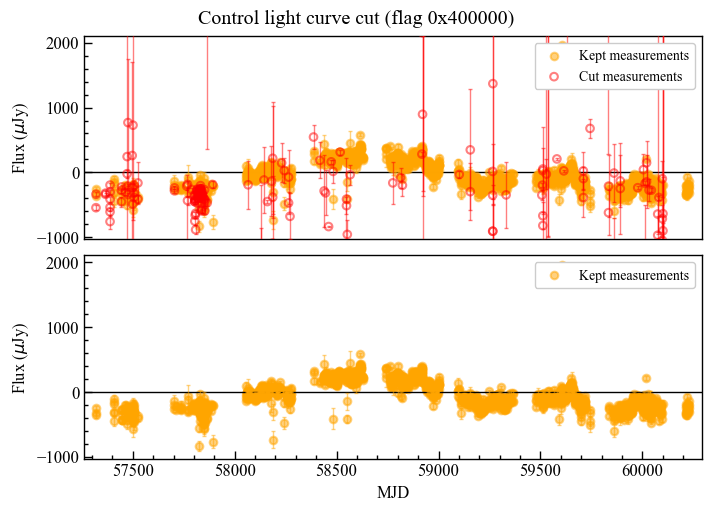

In [19]:
# Plot the light curve before and after the applied control light curve cut?:
plot = True

# Optionally, manually enter the x and y limits for the control light curve cut plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

if load_controls and plot:
    limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
    plot_cut_lc(lc, 'Control light curve cut', flags['controls_bad'], limits=limits, save_filename='controls_cut')

## Plot the ATLAS light curve with all previous cuts

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots/all_cut.png


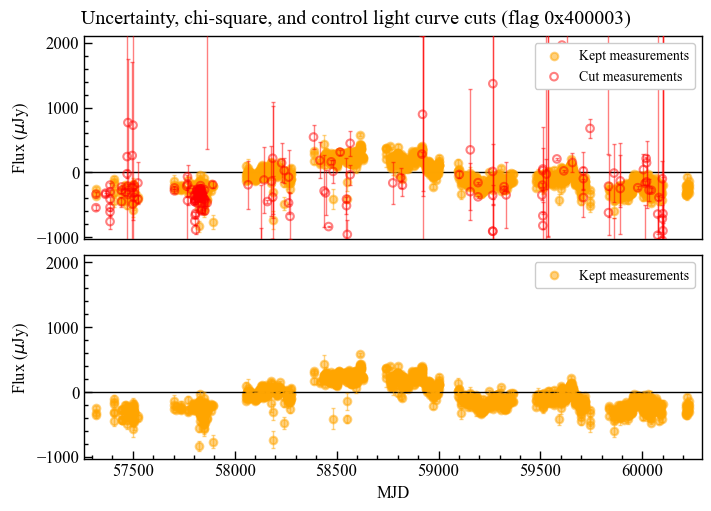

In [20]:
# Plot the light curve before and after all cuts?:
plot = True

# Optionally, manually enter the x and y limits for the plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

if plot:
    limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
    plot_cut_lc(lc, 'Uncertainty, chi-square, and control light curve cuts', flags['uncertainty']|flags['chisquare']|flags['controls_bad'], limits=limits, save_filename='all_cut')

## Step 6: Averaging and cutting bad bins

Our goal is to identify and cut out bad MJD bins by taking a 3σ-clipped average of each bin. For each bin, we calculate the 3σ-clipped average of any SN measurements falling within that bin and use that average as our flux for that bin. Because the ATLAS survey takes about 4 exposures every 2 days, we usually average together approximately 4 measurements per epoch. However, out of these 4 exposures, only measurements not cut in the previous methods are averaged in the 3σ-clipped average cut. (The exception to this statement would be the case that all 4 measurements are cut in previous methods; in this case, they are averaged anyway and flagged as a bad bin.)

Then we cut any measurements in the SN light curve for the given epoch for which statistics fulfill any of the following criteria: 
- A returned chi-square > 4.0
- Number of measurements averaged < 2
- Number of measurements clipped > 1

For this part of the cleaning, we still need to improve the cutting at the peak of the SN (important epochs are sometimes cut, maybe due to fast rise, etc.).

In [21]:
# Enter the MJD bin size in days:
mjd_bin_size = 1

# Should MJD bins with no measurements be translated as NaN (True) 
# or removed from the averaged light curve (False)?
keep_empty_bins = True

# After flux is averaged, average magnitudes are calculated using a flux-to-magnitude conversion.
# Magnitudes are limits if the dmagnitude is NaN. Enter these magnitudes' sigma limit:
flux2mag_sigmalimit = 3

# Enter the bound for a bin's maximum number of clipped measurements
# (if Nclip > Nclip_max, flag day):
Nclip_max = 1

# Enter the bound for a bin's minimum number of good measurements
# (if Ngood < Ngood_min, flag day):
Ngood_min = 2

# Enter the bound for a bin's maximum chi-square (if x2 > x2_max, flag day):
x2_max = 4.0

In [22]:
if len(lc.lcs[0].t) < 1:
    print('ERROR: No data in lc so cannot average; exiting... ')
    sys.exit()

print('\nAveraging light curve(s)...')
avglc = CleanAtlasLightCurve(lc.filt, 
                             tnsname=lc.tnsname, 
							 is_averaged=True, 
							 mjd_bin_size=mjd_bin_size, 
							 discdate=lc.discdate)

print('# Parameters: MJD bin size = %0.1f day(s), Nclip_max = %d, Ngood_min = %d, x2_max = %0.2f... ' % (mjd_bin_size, Nclip_max, Ngood_min, x2_max))
for control_index in range(lc.num_controls+1):
    avglc = lc._average(avglc, flags, Nclip_max, Ngood_min, x2_max, control_index=control_index, mjd_bin_size=mjd_bin_size, flux2mag_sigmalimit=flux2mag_sigmalimit)

nonnull_ix = avglc.lcs[0].ix_not_null('MJD')
percent_cut = 100 * len(avglc.lcs[0].ix_masked('Mask',maskval=flags['avg_badday'], indices=nonnull_ix)) / len(nonnull_ix)
s = 'Total percent of binned data flagged (%s): %0.2f%%' % (hex(flags['avg_badday']), percent_cut) 
print(f'# {s}')
output = f'{s}.'
f.write(f'\n\n## Averaging cleaned light curves\n{output}')
print('Success')


Averaging light curve(s)...
# Parameters: MJD bin size = 1.0 day(s), Nclip_max = 1, Ngood_min = 2, x2_max = 4.00... 
Now averaging SN light curve...
# Dropping extra columns (SN light curve):  ['__tmp_SN']
Now averaging control light curve 001...
# Dropping extra columns (control light curve 1):  ['__tmp_SN']
Now averaging control light curve 002...
# Dropping extra columns (control light curve 2):  ['__tmp_SN']
Now averaging control light curve 003...
# Dropping extra columns (control light curve 3):  ['__tmp_SN']
Now averaging control light curve 004...
# Dropping extra columns (control light curve 4):  ['__tmp_SN']
Now averaging control light curve 005...
# Dropping extra columns (control light curve 5):  ['__tmp_SN']
Now averaging control light curve 006...
# Dropping extra columns (control light curve 6):  ['__tmp_SN']
Now averaging control light curve 007...
# Dropping extra columns (control light curve 7):  ['__tmp_SN']
Now averaging control light curve 008...
# Dropping extra 

### Plot the averaged light curve and bad day cut

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2018gkr/plots/averaged.png


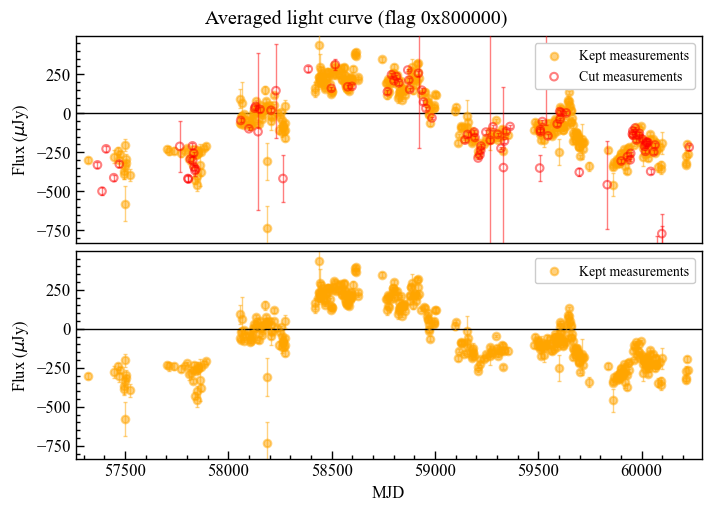

In [23]:
# Optionally, manually enter the x and y limits for the averaged light curve plot:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

# Plot the averaged light curve before and after the bad day cut?
plot = True

if plot:
    limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
    plot_cut_lc(avglc, 'Averaged light curve', flags['avg_badday'], limits=limits, save_filename='averaged')

## Optional: Correct for ATLAS reference template changes

This notebook takes into account ATLAS's periodic replacement of the difference image reference templates, which may cause step discontinuities in flux. Two template changes have been recorded at MJDs 58417 and 58882. More information can be found here: https://fallingstar-data.com/forcedphot/faq/.

In [24]:
# Set to True for ATLAS template change correction
template_correction = True

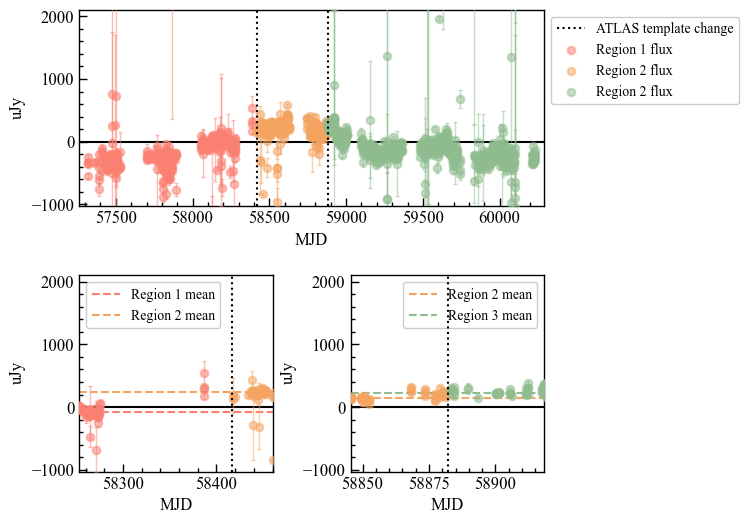

In [25]:
# 3-panel plot of (1) template regions in different colors and (2) zoom-in on transitions

def plot_template_correction(lc, limits=None):
    colors = ['salmon', 'sandybrown', 'darkseagreen']
    
    t1, t2 = 58417, 58882
    region1_ix = lc.lcs[0].ix_inrange('MJD', uplim=t1)
    region2_ix = lc.lcs[0].ix_inrange('MJD', lowlim=t1, uplim=t2)
    region3_ix = lc.lcs[0].ix_inrange('MJD', lowlim=t2)

    region1_mean = lc._get_mean(region1_ix[-40:]) # last 40 measurements before t1
    region2a_mean = lc._get_mean(region2_ix[:40]) # first 40 measurements after t1
    region2b_mean = lc._get_mean(region2_ix[-40:]) # last 40 measurements before t2
    region3_mean = lc._get_mean(region3_ix[:40]) # first 40 measurements after t2

    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.35, wspace=0.4)
    fig = plt.figure()
    fig.set_figwidth(6)
    fig.set_figheight(6)
    fig.tight_layout()

    ax1 = plt.subplot(gs[0, :])
    ax1.axvline(x=t1, color='k', linestyle='dotted', label='ATLAS template change', zorder=100)
    ax1.axvline(x=t2, color='k', linestyle='dotted', zorder=100)
    ax1.axhline(color='k',zorder=0)
    limits = set_xylimits(lc, limits)
    ax1.set_xlim(limits[0], limits[1])
    ax1.set_ylim(limits[2], limits[3])

    ax1.errorbar(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], yerr=lc.lcs[0].t.loc[region1_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[0], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax1.scatter(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[0], marker='o', alpha=0.5, zorder=10, label='Region 1 flux')
    ax1.errorbar(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], yerr=lc.lcs[0].t.loc[region2_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[1], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax1.scatter(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[1], marker='o', alpha=0.5, zorder=10, label='Region 2 flux')
    ax1.errorbar(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], yerr=lc.lcs[0].t.loc[region3_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[2], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax1.scatter(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[2], marker='o', alpha=0.5, zorder=10, label='Region 2 flux')

    ax1.legend(facecolor='white', framealpha=1, loc='upper left',  bbox_to_anchor=(1, 1))

    ax2 = plt.subplot(gs[1, 0])
    ax2.axvline(x=t1, color='k', linestyle='dotted', zorder=100)
    ax2.axhline(color='k',zorder=0)
    ax2.set_xlim(lc.lcs[0].t.loc[region1_ix[-40:][0], 'MJD'], lc.lcs[0].t.loc[region2_ix[:40][-1], 'MJD'])

    ax2.errorbar(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], yerr=lc.lcs[0].t.loc[region1_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[0], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[0], marker='o', alpha=0.5, zorder=10)
    ax2.errorbar(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], yerr=lc.lcs[0].t.loc[region2_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[1], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[1], marker='o', alpha=0.5, zorder=10)

    ax2.axhline(y=region1_mean, color=colors[0], linestyle='dashed', label='Region 1 mean')
    ax2.axhline(y=region2a_mean, color=colors[1], linestyle='dashed', label='Region 2 mean')

    limits = set_xylimits(lc, limits, indices=AorB(region1_ix[-40:], region2_ix[:40]))
    ax2.set_ylim(limits[2], limits[3])
    ax2.legend(facecolor='white', framealpha=1)

    ax3 = plt.subplot(gs[1, 1]) 
    ax3.axvline(x=t2, color='k', linestyle='dotted', zorder=100)
    ax3.axhline(color='k',zorder=0)
    ax3.set_xlim(lc.lcs[0].t.loc[region2_ix[-40:][0], 'MJD'], lc.lcs[0].t.loc[region3_ix[:40][-1], 'MJD'])
    ax3.set_ylim(limits[2], limits[3])

    ax3.errorbar(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], yerr=lc.lcs[0].t.loc[region2_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[1], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax3.scatter(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[1], marker='o', alpha=0.5, zorder=10)
    ax3.errorbar(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], yerr=lc.lcs[0].t.loc[region3_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[2], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
    ax3.scatter(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[2], marker='o', alpha=0.5, zorder=10)

    ax3.axhline(y=region2b_mean, color=colors[1], linestyle='dashed', label='Region 2 mean')
    ax3.axhline(y=region3_mean, color=colors[2], linestyle='dashed', label='Region 3 mean')

    limits = set_xylimits(lc, limits, indices=AorB(region2_ix[-40:], region3_ix[:40]))
    ax3.set_ylim(limits[2], limits[3])
    ax3.legend(facecolor='white', framealpha=1)

    for ax in (ax1, ax2, ax3):
        ax.minorticks_on()
        ax.tick_params(direction='in', which='both')
        ax.set_xlabel('MJD')
        ax.set_ylabel('uJy')

    plt.show()

if template_correction:
    plot_template_correction(lc, limits=[None]*4)

In [26]:
# Optionally enter manual offsets for each region (set each to None for automatic correction)
global_offset = 350
region1_offset = 0 + global_offset
region2_offset = 50 + global_offset
region3_offset = -50 + global_offset

In [27]:
if template_correction:
    output = lc.template_correction(maskval=0x1|0x2|0x400000|0x800000, 
                                    region1_offset=region1_offset, 
                                    region2_offset=region2_offset, 
                                    region3_offset=region3_offset)
    f.write(f'\n\n## ATLAS template change correction\n{output}')
else:
    print('Skipping template correction')


Correcting light curve flux due to template changes...
# Proceeding with manual template correction...
# Setting current offset to 0...
# Corrective flux 350.00 uJy added to first region
## Recording offset 350.00...
# Corrective flux 400.00 uJy added to second region
## Recording offset 400.00...
# Corrective flux 300.00 uJy added to third region
## Recording offset 300.00...


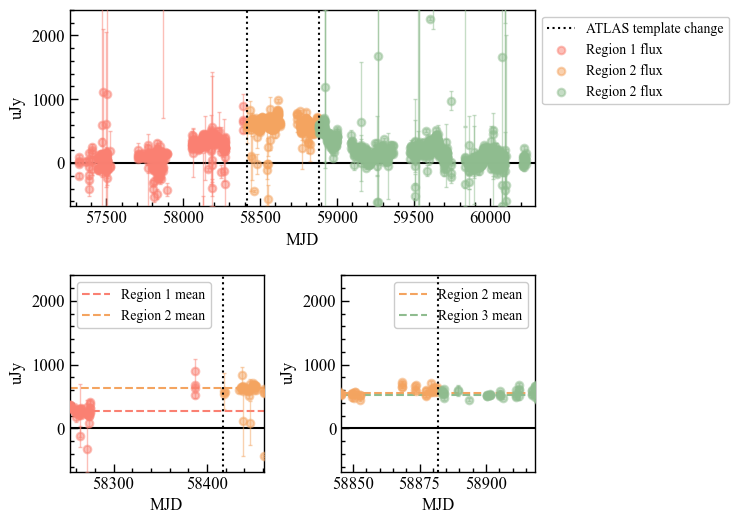

In [28]:
if template_correction:
    plot_template_correction(lc, limits=[None]*4)

## Optional: save the SN light curve with the new `'Mask'` and `'duJy_new'` columns

Hex values in the `'Mask'` column for each cut's flag:
- Uncertainty cut: 0x2
- Chi-square cut: 0x1
- Control light curve cut: 0x400000
- Bad day (for averaged light curves): 0x800000

You can combine these hex values together to create certain combinations of cuts that define a "bad" measurement.

In [29]:
# save the SN and control light curves?:
save_lc = False

# save the SN and control averaged light curves?:
save_avglc = False

In [30]:
if save_lc:
    print('Saving light curve with updated mask column...')
    lc._save(source_dir, filt=filt, overwrite=True)

In [31]:
if save_avglc:
    print('Saving averaged light curve with updated mask column...')
    avglc._save(source_dir, filt=filt, overwrite=True)

## Summary

In [32]:
# save and print summary of all cuts and corrections

f.close()
f1 = open(f'{source_dir}/{tnsname}/{tnsname}_output.md')
content = f1.read()
print()
print(content)
f1.close()


# SN 2018gkr Light Curve Cleaning and Averaging

Filter: o-band
Discovery date: 58207.146991
Number of control light curves: 8

## Uncertainty cut
Total percent of data flagged (0x2): 3.91%

## True uncertainties estimation
We increase the typical uncertainties from 20.00 to 24.38 by adding an additional systematic uncertainty of 13.94 in quadrature
The extra noise was added to the uncertainties of the SN light curve and copied to the "duJy_new" column

## Control light curve cut
Percent of data above x2_max bound (0x100): 0.84%
Percent of data above stn_max bound (0x200): 3.28%
Percent of data above Nclip_max bound (0x400): 0.08%
Percent of data below Ngood_min bound (0x800): 4.12%
Total percent of data flagged as questionable (not masked with control light curve flags but Nclip > 0) (0x80000): 2.52%
Total percent of data flagged as bad (0x400000): 8.11%

## Averaging cleaned light curves
Total percent of binned data flagged (0x800000): 19.37%.

## ATLAS template change correction
##